<a href="https://colab.research.google.com/github/avner8943/bootcamp/blob/master/radvess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from zipfile import ZipFile as zp
import cv2
import os
import numpy as np
import shutil
from glob import glob
import pickle
from tqdm import tqdm
from skimage.io import imread_collection
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def save_face(im, count,vid_dir):

  gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

  faces = face_cascade.detectMultiScale(gray, 1.1, 4)

  x,y,w,h = faces[0]

  face_crop = gray[y:y+h,x:x+w]

  face_crop = cv2.resize(face_crop, (128,128), interpolation = cv2.INTER_AREA)

  cv2.imwrite(vid_dir + "/frame_{d}.jpg".format(d = count), face_crop)


####################################


def load_data(save_pickle = 1):



  for zip_f in glob('*.zip'):

      print(zip_f)

      actor_dir = zip_f[:-4]

      if os.path.isdir(actor_dir):
        shutil.rmtree(actor_dir)

      os.mkdir(actor_dir)

      with zp('/content/'+zip_f) as myzip:
        

        for f in myzip.infolist()[1:]:

          print(f)
          
          #vid_dir = os.path.join( actor_dir, f.filename[:-4])

          vid_dir =  f.filename[:-4]

          os.mkdir(vid_dir )

          ifile = myzip.extract(f)
          
          vidcap = cv2.VideoCapture(ifile)
             
          n_frames = np.floor((vidcap.get(cv2.CAP_PROP_FRAME_COUNT))).astype(np.int)

          frames_list = list(np.linspace(0,n_frames,60, dtype=np.int))


          success,image = vidcap.read()
          count = 0
          while success:
            if count in frames_list:
                
                save_face(image, count,vid_dir)

                if count % 10 == 0:

                  print("zip: ", zip_f, '/',len(glob('*.zip')), ", vid: ", vid_dir,'/',len(myzip.infolist()[1:]), ", frame: " , count, '/', n_frames)
                     
            success,image = vidcap.read()
            count += 1
          os.remove(ifile)
  
  
  if save_pickle == 1:
    print("picle start")
    images2pickle()

##############################################

def images2pickle(path=None):

  print("for real")

  dirs = glob("/content/*/")

  x = []
  y = []

  for dir in dirs:
    if dir.find('Actor') == -1: continue

    sub_dirs = glob(os.path.join(dir,'*/'))

    for sub_dir in sub_dirs:

      images = np.array(imread_collection(os.path.join(sub_dir, '*.jpg')))

      x.append(images)

      tag = sub_dir.split('/')[3][7]

      y.append(tag)



  x = np.array(x)

  y = np.array(y)

  print(y)
  

  label_encoder = LabelEncoder()
  integer_encoded = label_encoder.fit_transform(y)
  print(integer_encoded)


  onehot_encoder = OneHotEncoder(sparse=False)
  integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
  y = onehot_encoder.fit_transform(integer_encoded)
  print(y)

  z = input(" weight for user to press enter...")

  with open('radvess_data_for_train.pickle', 'wb') as output:
    pickle.dump(x, output)

  with open('radvess_tags_for_train.pickle', 'wb') as output:
    pickle.dump(y, output)


####################################################

def load_pickle(path):

  with open(path, 'rb') as data:
    return pickle.load(data)




In [12]:
#load_data()

x = load_pickle('/content/radvess_data_for_train.pickle')

#x = x.reshape(x.shape[0], x.shape[2], x.shape[3], x.shape[1])

print(x.shape)

x = np.expand_dims(x, axis=4)



(12, 59, 128, 128)


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths

In [69]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

x = load_pickle('radvess_data_for_train.pickle')

x = x.astype('float64')

x = np.expand_dims(x,axis = 4)

print(x.shape)

y = load_pickle('radvess_tags_for_train.pickle')

y = y.astype('float64')

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.2, random_state=42)

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    )

datagen.fit(x_train)





# load the ResNet-50 network, ensuring the head FC layer sets are left
# off
baseModel = ResNet50(weights="imagenet", include_top=False,
	        input_tensor=Input(shape=(128,128,59)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(lb.classes_), activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the training process
for layer in baseModel.layers:
	layer.trainable = False

(12, 59, 128, 128, 1)


ValueError: ignored

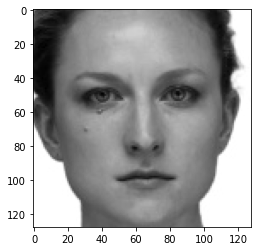

In [70]:
x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.2, random_state=42)

plt.imshow(x_train[0,0,:,:,0], cmap='gray')


In [32]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pylab as plt

seq = keras.Sequential(
    [
        keras.Input(
            shape=(59, 128, 128, 1)
        ),  # Variable-length sequence of 40x40x1 frames
        layers.ConvLSTM2D(
            filters=40, kernel_size=(3, 3), padding="same", return_sequences=True
        ),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(
            filters=40, kernel_size=(3, 3), padding="same", return_sequences=True
        ),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(
            filters=40, kernel_size=(3, 3), padding="same", return_sequences=True
        ),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(
            filters=40, kernel_size=(3, 3), padding="same", return_sequences=True
        ),
        layers.BatchNormalization(),
        layers.Conv3D(
            filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
        ),
    ]
)
#seq.compile(loss="categorical_crossentropy", optimizer="adadelta")

seq.predict(x_train).shape


(9, 59, 128, 128, 1)

In [ ]:
seq.fit(
    x_train,
    y_train,
    batch_size=10,
    epochs=1,
    verbose=2,
    validation_split=0.1,
)

In [37]:
from keras.models import Sequential
from keras.layers import ConvLSTM2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.models import Model

In [48]:
model = Sequential()
model.add(ConvLSTM2D(1, kernel_size=(3, 3), activation='tanh', recurrent_activation='hard_sigmoid', 
                        kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal',
                        kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, 
                        return_sequences=False,
                        padding='same',
                        data_format='channels_last',
                        dropout=0.0, recurrent_dropout=0.0))

model.compile(optimizer=Adam(decay=1e-4),
              loss='mean_squared_error',
              metrics=['accuracy'])

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'crime_prediction.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer]

model.fit(x_train, y_train,
          batch_size=120,
          epochs=20,
          validation_data=(x_test, y_test),
          shuffle=True,
          callbacks=callbacks)

model.summary()

from keras.utils import plot_model
plot_model(model, to_file='model.png')

# Score trained model.
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Epoch 1/20


InvalidArgumentError: ignored

In [71]:
from tensorflow.keras.layers import Activation,MaxPooling3D,Reshape,LSTM

def load_model():
    # use simple CNN structure
    in_shape = (59, 128, 128, 1)
    model = Sequential()
    model.add(ConvLSTM2D(32, kernel_size=(7, 7), padding='valid', return_sequences=True, input_shape=in_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(1, 2, 2)))
    model.add(ConvLSTM2D(64, kernel_size=(5, 5), padding='valid', return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1, 2, 2)))
    model.add(ConvLSTM2D(96, kernel_size=(3, 3), padding='valid', return_sequences=True))
    model.add(Activation('relu'))
    model.add(ConvLSTM2D(96, kernel_size=(3, 3), padding='valid', return_sequences=True))
    model.add(Activation('relu'))
    model.add(ConvLSTM2D(96, kernel_size=(3, 3), padding='valid', return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1, 2, 2)))
    model.add(Dense(320))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    out_shape = model.output_shape
    print('====Model shape: ', out_shape)
    model.add(Reshape((59, out_shape[2] * out_shape[3] * out_shape[4])))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(8, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

    # model structure summary
    print(model.summary())

    return model 

model = load_model()


model.fit(x_train, y_train,
          batch_size=120,
          epochs=20,
          validation_data=(x_test, y_test),
          shuffle=True)

====Model shape:  (None, 59, 11, 11, 320)
Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_100 (ConvLSTM2D (None, 59, 122, 122, 32)  207104    
_________________________________________________________________
activation_29 (Activation)   (None, 59, 122, 122, 32)  0         
_________________________________________________________________
max_pooling3d_21 (MaxPooling (None, 59, 61, 61, 32)    0         
_________________________________________________________________
conv_lst_m2d_101 (ConvLSTM2D (None, 59, 57, 57, 64)    614656    
_________________________________________________________________
max_pooling3d_22 (MaxPooling (None, 59, 28, 28, 64)    0         
_________________________________________________________________
conv_lst_m2d_102 (ConvLSTM2D (None, 59, 26, 26, 96)    553344    
_________________________________________________________________
activation_

ValueError: ignored

In [72]:
y_train

array([1., 1., 1., 1., 1., 1., 1., 1., 1.])